torch.utils.data.DataLoader : Dataset을 샘플에 쉽게 접근할 수 있도록 반복 가능한 객체로 감싸음  
torch.utils.data.Dataset : 샘플과 정답을 저장함  
torch.utils.data.Dataset 밑에 이미지, 텍스트, 오디오 데이터 셋이 있음

#Fashion-MNIST 데이터 셋 예제

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [4]:
training_data = datasets.FashionMNIST(
    root="data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train = False,
    download = True,
    transform = ToTensor()
)


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#데이터 셋을 반복하고 시각화하기, index를 통해 직접 시각화

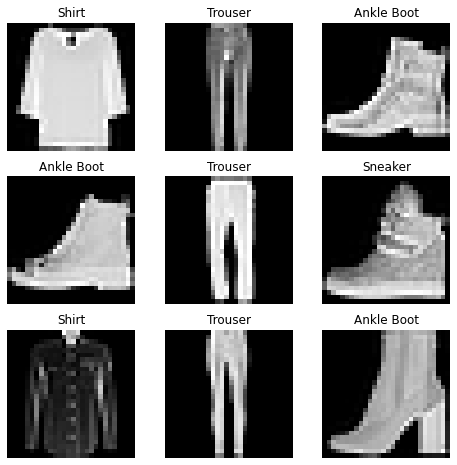

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    #sqeeze는 압축..?
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


파일에서 사용자 정의 데이터셋 만들기  
Dataset 클래스는 반드시 3 개 함수를 구현   

1.   __init__
2.   __len__
3.   __getitem__


아래 이미지들은, img_dir 디렉토리에 저장되고, 정답은 annotations_file csg에 별도로 저장

labels.csv  
tshirt1.jpg, 0  
tshirt2.jpg, 0  
......  
ankleboot999.jpg, 9

In [6]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
  #이미지와 주석 파일이 포함된 디렉토리와, 두가지 변형을 초기화함
  def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotaions_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform
  #데이터 셋의 샘플 개수를 반환
  def __len__(self):
    return len(self.img_labels)
  
  #주어진 인덱스에 해당하는 샘플을 데이터셋에서 불러오고 반환
  #인덱스를 기반으로, 디스크에서 이미지 위치를 실벽하고
  #read_image를 사용하여 이미지를 텐서로 변환하고
  #self.img_labels 의 csv 데이터로부터 해당하는 정답을 가져오고, 해당하는 경우 변형(transform) 함수를 호출한 뒤
  #텐서 이미지와 라벨을 dict 형으로 반환
  def __getitem__(self,idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx,1]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image,label

#DataLoader 로 학습용 데이터 준비하기  
Dataset은 데이터셋의 특징을 가져오고, 하나의 샘플에 정답을 지정하는 일을 한 번에 합니다.  
일반적으로 샘플들을 미니배치로 전달하고, 매 에폭마다 데이터를 다시 섞어서 과적하(overfit)을 막고, multiprocessing을 사용하여 데이터 검색 속도를 높이려고 합니다.

DataLoader은 간단한 API 로 이러한 복잡한 과정들을 추상화한 반복 가능한 객체입니다.

In [7]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)

#DataLoader을 통해 반복하기  
DataLoader에 데이터 셋을 불러온 뒤에는 필요에 따라 데이터셋을 반복할 수 있습니다. 아래의 각 반복은 (각각 batchsize=64 의 특징과 정답을 포함하는) train_features, train_labels, 의 묶음 (batch)을 반환합니다.  
shuffle = True이므로 모든 배치를 반복한 뒤 데이터가 섞입니다.  
samplers를 통해 데이터 불러오는 순서를 세밀하게 제어할 수 있다한다... 나중에 보자

Feature batch shape : torch.Size([64, 1, 28, 28])
Feature batch shape : torch.Size([64])


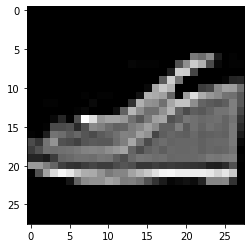

Label:5


In [9]:
train_features,train_labels = next(iter(train_dataloader))
print(f"Feature batch shape : {train_features.size()}")
print(f"Feature batch shape : {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img,cmap="gray")
plt.show()
print(f"Label:{label}")